# 导入模块 以及标签

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import torch.nn.functional as F
from torch.autograd import Variable

import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from torchmetrics.classification import Accuracy
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'




label_map = {
    769: "OVTK_GDF_Left",
    770: "OVTK_GDF_Right",
    780: "OVTK_GDF_Up",
    774: "OVTK_GDF_Down",
    32769: "OVTK_StimulationId_ExperimentStart",
    32775: "OVTK_StimulationId_BaselineStart",
    33026: "OVTK_GDF_Feedback_Continuous"
}




channel_cols = [
    'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4',
    'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8'
]   

# 清洗数据

In [ ]:
df = pd.read_csv('/home/sanji/data/eeg/motor-imagery-1-[2025.02.19-16.17.02].csv')
df.drop(columns=["Channel 9", "Channel 10", "Channel 11"], inplace=True)

def keep_first_part(x):
    if not isinstance(x, str):
        x = "" if pd.isna(x) else str(x)
    return x.split(":")[0] if x else ""

for col in ["Event Id", "Event Date", "Event Duration"]:
    df[col] = df[col].fillna("").apply(keep_first_part)

same_mask = df["Event Id"] == df["Event Id"].shift(-1)
rows_to_blank = same_mask.index[same_mask]
rows_to_blank = rows_to_blank + 1
rows_to_blank = rows_to_blank[rows_to_blank < len(df)]
df.loc[rows_to_blank, ["Event Id", "Event Date", "Event Duration"]] = ""
df["Event Id"] = pd.to_numeric(df["Event Id"], errors="coerce")
df["Event Date"] = pd.to_numeric(df["Event Date"], errors="coerce")
# df.to_csv("processed_data.csv", index=False)

In [15]:
df.head()

,Time:250Hz,Epoch,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Event Id,Event Date,Event Duration
0,0.000,0,6128.468262,-4222.713867,-17217.906250,-41934.261719,-47012.066406,26170.271484,14958.591797,30611.382812,NaN,NaN,
1,0.004,0,6120.443848,-4227.318359,-17224.343750,-41940.675781,-47019.128906,26119.644531,14935.122070,30564.958984,32769.0,0.007105,0.0000000000
2,0.008,0,6127.238770,-4216.075195,-17220.386719,-41938.867188,-47015.371094,26068.994141,14915.273438,30518.265625,NaN,NaN,
3,0.012,0,6136.961914,-4210.777832,-17210.328125,-41936.320312,-47013.964844,26084.105469,14923.566406,30532.125000,NaN,NaN,
4,0.016,0,6128.937500,-4229.642578,-17210.439453,-41938.531250,-47019.976562,26156.501953,14953.406250,30601.326172,NaN,NaN,


# 转换为MNE格式并陷阱滤波50HZ

In [16]:
data = df[channel_cols].to_numpy().T
ch_names = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'] 
ch_types = ['eeg'] * 8
sfreq = 250.0
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)
raw.notch_filter(freqs=[50], picks='eeg')

print(raw)

Creating RawArray with float64 data, n_channels=8, n_times=124256
    Range : 0 ... 124255 =      0.000 ...   497.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

<RawArray | 8 x 124256 (497.0 s), ~7.6 MB, data loaded>


# 处理标签

In [ ]:
df['Event Id'] = df['Event Id'].fillna(0).astype(int)
event_rows = df.index[df['Event Id'] != 0]
event_codes = df.loc[event_rows, 'Event Id'].values
events = np.column_stack((
    event_rows,            # 第一列：采样点
    np.zeros_like(event_rows),  # 第二列：0
    event_codes           # 第三列：事件编码
))

event_id_dict = {
    'left': 769,
    'right': 770,
    'up':780,
    'down':774
}

array([32769, 32775, 32776,   768, 33282,   770,   781,   800,   768,
       33282,   769,   781,   800,   800,   768, 33282,   770,   781,
         800,   768, 33282,   770,   781,   800,   768, 33282,   770,
         781,   800,   768, 33282,   770,   781,   800,   768, 33282,
         769,   781,   800,   768, 33282,   769,   781,   800,   768,
       33282,   769,   769,   781,   800,   768, 33282,   770,   781,
         800,   768, 33282,   770,   781,   800,   768, 33282,   770,
         781,   800,   768, 33282,   770,   781,   800,   768, 33282,
         769,   781,   800,   768, 33282,   769,   781,   800,   768,
       33282,   769,   781,   800,   768, 33282,   769,   781,   800,
         768, 33282,   770,   781,   800,   768, 33282,   770,   781,
         800,   898, 33282,   770,   781,   800,   768, 33282,   769,
         781,   800,   768, 33282,   770,   781,   800,   768, 33282,
         770,   781,   800,   768, 33282,   769,   781,   800,   768,
       33282,   770,

In [ ]:
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id_dict,
    tmin=0.0,
    tmax=3.0,
    baseline=None,    # 不做基线校正
    picks='eeg',
    preload=True
)

print("Number of valid epochs:", len(epochs))

Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 42 events and 751 original time points ...
0 bad epochs dropped
Number of valid epochs: 42


In [ ]:
X = (epochs.get_data() * 1e-6).astype(np.float32)  # 如果需要单位转换(微伏/毫伏)，可做 * 1e-6 或 *1e3
X = X.astype(np.float32)
raw_labels = epochs.events[:, 2]
label_map = {769:0, 770:1,780:2,774:3}
y = np.array([label_map[val] for val in raw_labels], dtype=np.int64)

/tmp/ipykernel_1282/1674647049.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = (epochs.get_data() * 1e-6).astype(np.float32)  # 如果需要单位转换(如原始是微伏/毫伏)，可做 * 1e-6 或 *1e3


In [28]:
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (42, 8, 751) y shape: (42,)


In [ ]:
class EEGDataset(torch_data.Dataset):
    def __init__(self, x, y=None, split=None):
        # x: (n_samples, n_channels, n_times)
        # y: (n_samples, )
        super().__init__()
        self.split = split
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        X_ = torch.from_numpy(self.x[idx])   # shape=(n_channels, n_times)
        if self.y is not None:
            y_ = torch.tensor(self.y[idx]).long()
            return X_, y_
        else:
            return X_

n_total = len(X)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

train_X = X[:n_train]
train_y = y[:n_train]
val_X   = X[n_train:n_train+n_val]
val_y   = y[n_train:n_train+n_val]
test_X  = X[n_train+n_val:]
test_y  = y[n_train+n_val:]

train_dataset = EEGDataset(train_X, train_y)
val_dataset   = EEGDataset(val_X, val_y)
test_dataset  = EEGDataset(test_X, test_y)

print("Train/Val/Test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))


Train/Val/Test sizes: 33 4 5


In [48]:
n_epochs, n_channels, n_times = 100, 8, 250  # 100段, 8通道, 每段250采样
X = np.random.randn(n_epochs, n_channels, n_times).astype(np.float32)
y = np.random.randint(0, 2, size=(n_epochs,))

########################################################
# 1) 定义自定义 Dataset
########################################################
class EEGDataset(torch_data.Dataset):
    def __init__(self, x, y=None, inference=False):
        super().__init__()
        self.__split = None

        N_SAMPLE = x.shape[0]
        val_idx = int(0.9 * N_SAMPLE)
        train_idx = int(0.81 * N_SAMPLE)

        if not inference:
            self.train_ds = {
                'x': x[:train_idx],
                'y': y[:train_idx],
            }
            self.val_ds = {
                'x': x[train_idx:val_idx],
                'y': y[train_idx:val_idx],
            }
            self.test_ds = {
                'x': x[val_idx:],
                'y': y[val_idx:],
            }
        else:
            self.inference_ds = {'x': x}

    def __len__(self):
        return len(self.dataset['x'])

    def __getitem__(self, idx):
        x_ = torch.tensor(self.dataset['x'][idx], dtype=torch.float32)  # shape=(8, 250)
        if self.__split != "inference":
            y_ = torch.tensor(self.dataset['y'][idx], dtype=torch.float32).unsqueeze(-1)  # shape=(1,)
            return x_, y_
        else:
            return x_

    def split(self, __split):
        self.__split = __split
        return self

    @property
    def dataset(self):
        assert self.__split is not None, "Specify the split!"
        if self.__split == "train":
            return self.train_ds
        elif self.__split == "val":
            return self.val_ds
        elif self.__split == "test":
            return self.test_ds
        elif self.__split == "inference":
            return self.inference_ds
        else:
            raise TypeError("Unknown dataset split!")

eeg_dataset = EEGDataset(X, y)

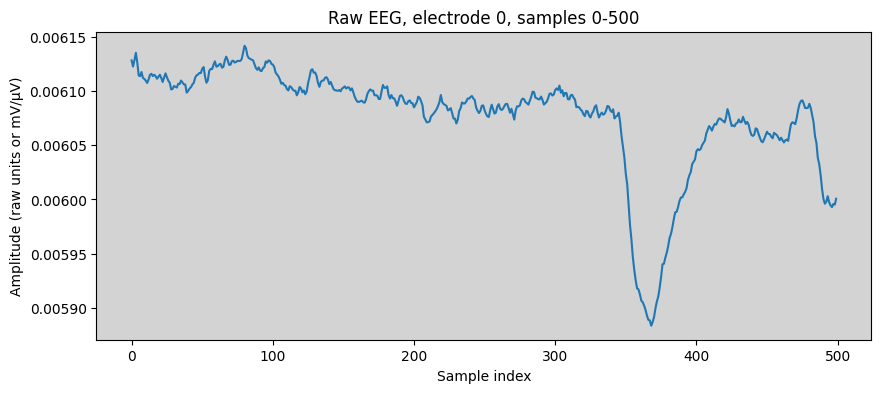

<Figure size 640x480 with 0 Axes>

In [ ]:
sample_raw_data = raw.get_data()[0, :500]  # shape=(500,)

# 直接使用 plt.plot
plt.figure(figsize=(10, 4))  # 可选：设置图像大小
plt.plot(sample_raw_data * 1e-6)
plt.title("Raw EEG, electrode 0, samples 0-500")
plt.ylabel("Amplitude (raw units or mV/µV)")
plt.xlabel("Sample index")
plt.show()
plt.clf()

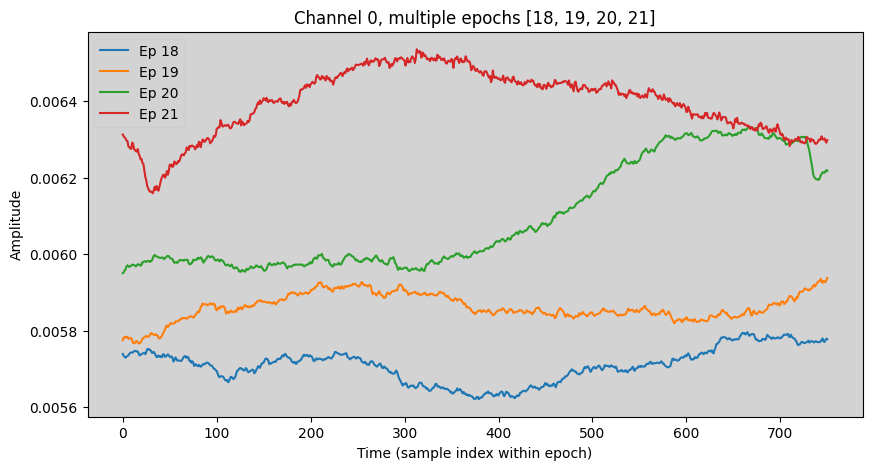

<Figure size 640x480 with 0 Axes>

In [ ]:
channel_idx = 0
epoch_range = [18,19,20,21]

data_for_plot = X[epoch_range, channel_idx, :]

data_for_plot = data_for_plot.T

plt.figure(figsize=(10, 5))
plt.plot(data_for_plot)
plt.title(f"Channel {channel_idx}, multiple epochs {epoch_range}")
plt.xlabel("Time ")
plt.ylabel("Amplitude")
plt.legend([f"Ep {ep}" for ep in epoch_range])
plt.show()
plt.clf()




# CNN+Transformer

In [ ]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

class ModelWrapper(L.LightningModule):
    def __init__(self, arch, dataset, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.dataset = dataset
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="multiclass", num_classes=4)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=4)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=4)

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch  # y.shape = (batch_size, 1)
        y_hat = self(x)  # shape=(batch_size,1)
        loss = loss = F.cross_entropy(y_hat, y.squeeze(-1).long())

        self.train_accuracy.update(y_hat, y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = loss = F.cross_entropy(y_hat, y.squeeze(-1).long())
        self.val_accuracy.update(y_hat, y)
        acc = self.val_accuracy.compute().data.cpu()

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = loss = F.cross_entropy(y_hat, y.squeeze(-1).long())
        self.test_accuracy.update(y_hat, y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", self.test_accuracy.compute(), prog_bar=True, logger=True)

    def on_train_end(self):
        loss_img_file = "loss_plot.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        
        acc_img_file = "acc_plot.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()

    def train_dataloader(self):
        return torch_data.DataLoader(
            dataset=self.dataset.split("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch_data.DataLoader(
            dataset=self.dataset.split("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return torch_data.DataLoader(
            dataset=self.dataset.split("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.25),
                    int(self.max_epoch * 0.5),
                    int(self.max_epoch * 0.75),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

# --- (C) PositionalEncoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.p = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens
        )
        self.p[:, :, 0::2] = torch.sin(x)
        self.p[:, :, 1::2] = torch.cos(x)

    def forward(self, x):
        x = x + self.p[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)

# --- (D) TransformerBlock ---
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim, num_heads, dropout, batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, embed_dim),
        )
        self.layernorm0 = nn.LayerNorm(embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.dropout = dropout

    def forward(self, x):
        y, att = self.attention(x, x, x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm0(x + y)
        y = self.mlp(x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm1(x + y)
        return x

# --- (E) EEGClassificationModel ---
class EEGClassificationModel(nn.Module):
    def __init__(self, eeg_channel, dropout=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(eeg_channel, eeg_channel, 11, 1, padding=5, bias=False),
            nn.BatchNorm1d(eeg_channel),
            nn.ReLU(True),
            nn.Dropout1d(dropout),
            nn.Conv1d(eeg_channel, eeg_channel * 2, 11, 1, padding=5, bias=False),
            nn.BatchNorm1d(eeg_channel * 2),
        )

        self.transformer = nn.Sequential(
            PositionalEncoding(eeg_channel * 2, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
        )

        self.mlp = nn.Sequential(
            nn.Linear(eeg_channel * 2, eeg_channel // 2),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(eeg_channel // 2, 4),
        )

    def forward(self, x):
        # x: (B, n_channels, n_times)
        x = self.conv(x)  # -> (B, eeg_channel*2, n_times)
        x = x.permute(0, 2, 1)  # -> (B, n_times, eeg_channel*2)
        x = self.transformer(x) # -> (B, n_times, eeg_channel*2)
        x = x.permute(0, 2, 1)  # -> (B, eeg_channel*2, n_times)
        x = x.mean(dim=-1)      # -> (B, eeg_channel*2)
        x = self.mlp(x)         # -> (B, 1)
        return x


In [ ]:

MAX_EPOCH = 600
BATCH_SIZE = 10
LR = 5e-4
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

print(X.shape)  # (100, 8, 250)  -> 100个epoch, 8个通道, 每个通道250采样点

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 2) 构建网络本身
base_model = EEGClassificationModel(eeg_channel=EEG_CHANNEL, dropout=0.125)

# 3) 用 ModelWrapper 封装成 LightningModule
wrapper = ModelWrapper(
    arch=base_model,
    dataset=eeg_dataset,
    batch_size=BATCH_SIZE,
    lr=LR,
    max_epoch=MAX_EPOCH
)

# 4) 使用 Lightning Trainer 来训练
trainer = L.Trainer(
    max_epochs=MAX_EPOCH,
    accelerator="auto",
    # 其余logger/callback等设置
)
trainer.fit(wrapper)
trainer.test(wrapper)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                   | Params | Mode 
------------------------------------------------------------------
0 | arch           | EEGClassificationModel | 4.6 K  | train
1 | train_accuracy | BinaryAccuracy         | 0      | train
2 | val_accuracy   | BinaryAccuracy         | 0      | train
3 | test_accuracy  | BinaryAccuracy         | 0      | train
------------------------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.019     Total estimated model params size (MB)


Random seed: 591071449
(100, 8, 250)
Epoch 599: 100%|██████████| 9/9 [00:00<00:00, 52.80it/s, v_num=9, train_loss=0.415, train_acc=0.912, val_loss=0.211, val_acc=0.973]  

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 9/9 [00:00<00:00, 48.09it/s, v_num=9, train_loss=0.415, train_acc=0.912, val_loss=0.211, val_acc=0.973]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 143.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7246428728103638
        test_loss           1.5935227870941162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5935227870941162, 'test_acc': 0.7246428728103638}]

<Figure size 640x480 with 0 Axes>